## In Context Learning - Ensemble

#### Import Libraries

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter

In [33]:
import os

# Set Constants
# If use Google Colab
use_colab = True
if use_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_PATH = "/content/drive/MyDrive/Colab Notebooks/CNL"
    device = "cuda"
else:
    ROOT_PATH = "G:\Drive'ım\Colab Notebooks\CNL"
    device = "cpu"

DATA_PATH = os.path.join(ROOT_PATH, 'data/v3')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Predicted CSV files

In [39]:
def load_data_from_csv(file_path):
    """
    CSV dosyasını yükler ve tahminleri ile gerçek cevapları ayırır.
    """
    df = pd.read_csv(file_path)
    true_answers = df["true_answer"].tolist()  # Gerçek cevaplar
    model_predictions = df["predicted_answer"].tolist()  # Model tahminleri
    questions = df["question"].tolist()  # Sorular
    return questions, true_answers, model_predictions, df

#### Clean predicted data, only choice letter

In [35]:
def clean_predictions(predictions):
    """
    Tahminleri temizler, yalnızca A, B, C, D'yi geçerli olarak kabul eder.
    """
    valid_choices = {"A", "B", "C", "D"}
    cleaned_predictions = []
    for pred in predictions:
        if isinstance(pred, str):
            clean_choice = pred.split()[0].strip(".").upper()  # Şık harfini al
            if clean_choice in valid_choices:
                cleaned_predictions.append(clean_choice)
            else:
                cleaned_predictions.append("Unknown")
        else:
            cleaned_predictions.append("Unknown")  # Geçersiz tahminler
    return cleaned_predictions

In [36]:
def print_sample_predictions(questions, true_answers, model_predictions, cleaned_predictions, dataset_name, num_samples=5):
    """
    Soruları, şıkları, gerçek cevapları, tahminleri ve temizlenmiş tahminleri yazdırır.
    """
    print(f"\n=== {dataset_name} Tahminleri (İlk {num_samples} Örnek) ===")
    for i in range(min(num_samples, len(true_answers))):
        print(f"Soru {i + 1}:")
        print(f"  {questions[i]}")
        print(f"  Gerçek Cevap: {true_answers[i]}")
        print(f"  Orijinal Tahmin: {model_predictions[i]}")
        print(f"  Temizlenmiş Tahmin: {cleaned_predictions[i]}")
        print("---")

In [37]:
def calculate_individual_performance(df, method_name):
    """
    Tekil başarıları hesaplar ve raporlar.
    """
    grouped = df.groupby("ensemble_id")
    accuracies = []
    for ensemble_id, group in grouped:
        true_answers = group["true_answer"].tolist()
        predictions = group["cleaned_answer"].tolist()
        accuracy = accuracy_score(true_answers, predictions)
        accuracies.append(accuracy)
        print(f"{method_name} - Ensemble ID {ensemble_id} Tekil Doğruluk: {accuracy:.4f}")
    return accuracies

def calculate_ensemble_performance(df, method_name):
    """
    Ensemble başarı oranını majority voting ile hesaplar.
    """
    grouped = df.groupby("question")
    correct = 0
    total = 0
    for question, group in grouped:
        votes = group["cleaned_answer"].dropna().tolist()
        if votes:
            most_common_answer = Counter(votes).most_common(1)[0][0]
            true_answer = group["true_answer"].iloc[0]
            if most_common_answer == true_answer:
                correct += 1
        total += 1
    accuracy = correct / total if total > 0 else 0
    print(f"{method_name} - Ensemble Doğruluk: {accuracy:.4f}")
    return accuracy


In [40]:
# ARC verilerini yükle ve temizle
arc_replacement_file = os.path.join(DATA_PATH, "arc_replacement_ensemble_results_OnlyChoice_ens5.csv")
arc_no_replacement_file = os.path.join(DATA_PATH, "arc_no_replacement_ensemble_results_OnlyChoice_ens5.csv")
arc_shuffled_file = os.path.join(DATA_PATH, "arc_shuffled_ensemble_results_OnlyChoice_ens5.csv")

questions_arc_Rep, true_answers_arc_Rep, model_predictions_arc_Rep, arc_replacement_df = load_data_from_csv(arc_replacement_file)
question_arc_noRep, true_answers_arc_noRep, model_predictions_arc_noRep, arc_no_replacement_df = load_data_from_csv(arc_no_replacement_file)
question_arc_Shuf, true_answers_arc_Shuf, model_predictions_arc_Shuf, arc_shuffled_df = load_data_from_csv(arc_shuffled_file)

# Tahminleri temizle
arc_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_arc_Rep)
arc_no_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_arc_noRep)
arc_shuffled_df["cleaned_answer"] = clean_predictions(model_predictions_arc_Shuf)

# Örnek çıktıları yazdır
print_sample_predictions(questions_arc_Rep, true_answers_arc_Rep, model_predictions_arc_Rep, arc_replacement_df["cleaned_answer"].tolist(), "ARC Replacement")


=== ARC Replacement Tahminleri (İlk 5 Örnek) ===
Soru 1:
  Periyodik tabloda hangi grup en az reaktif olan elementleri içerir?
Şıklar:
A. Grup 1 (1A)
B. Grup 3 (3B)
C. Grup 16 (6A)
D. Grup 18 (8A)
  Gerçek Cevap: D
  Orijinal Tahmin: A
Soru: Hangi organ, vücutta ısıyı düzenlemek için çok önemli
  Temizlenmiş Tahmin: A
---
Soru 2:
  Hangi ifade bilimsel bir keşfin olumlu etkisini tanımlar?
Şıklar:
A. Bu bazı insanları üzer.
B. Yararlı olması uzun zaman alır.
C. İşlerin nasıl yürüdüğünü açıklamaya yardımcı olur.
D. İşin daha zor olmasına neden olur.
  Gerçek Cevap: C
  Orijinal Tahmin: A
Soru: Aşağıdaki kavramlard
  Temizlenmiş Tahmin: A
---
Soru 3:
  Aşağıdakilerden hangisi televizyon yapımında kullanılan doğal kaynakları en iyi şekilde korur?
Şıklar:
A. bozuk televizyonu onarmak
B. indirimde olan bir televizyon satın almak
C. eski televizyonları çöpe atmak
D. okula yeni bir televizyon bağışlamak
  Gerçek Cevap: A
  Orijinal Tahmin: D (televizyon yapımında kullanılan doğal kaynakları k

In [72]:
# Replacement analizi
print("\n--- ARC-TR ---")
print("\n--- Replacement Performans Analizi ---\n")
replacement_individual_accuracies = calculate_individual_performance(arc_replacement_df, "Replacement")
replacement_ensemble_accuracy = calculate_ensemble_performance(arc_replacement_df, "Replacement")

# No Replacement
print("\n--- No Replacement Performans Analizi ---\n")
no_replacement_individual_accuracies = calculate_individual_performance(arc_no_replacement_df, "No Replacement")
no_replacement_ensemble_accuracy = calculate_ensemble_performance(arc_no_replacement_df, "No Replacement")

# Shuffle
print("\n--- Shuffle Performans Analizi ---\n")
shuffled_individual_accuracies = calculate_individual_performance(arc_shuffled_df, "Shuffle")
shuffled_ensemble_accuracy = calculate_ensemble_performance(arc_shuffled_df, "Shuffle")



--- ARC-TR ---

--- Replacement Performans Analizi ---

Replacement - Ensemble ID 1 Tekil Doğruluk: 0.3225
Replacement - Ensemble ID 2 Tekil Doğruluk: 0.3625
Replacement - Ensemble ID 3 Tekil Doğruluk: 0.4100
Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2925
Replacement - Ensemble ID 5 Tekil Doğruluk: 0.4375
Replacement - Ensemble Doğruluk: 0.4350

--- No Replacement Performans Analizi ---

No Replacement - Ensemble ID 1 Tekil Doğruluk: 0.3975
No Replacement - Ensemble ID 2 Tekil Doğruluk: 0.4725
No Replacement - Ensemble ID 3 Tekil Doğruluk: 0.4700
No Replacement - Ensemble ID 4 Tekil Doğruluk: 0.4600
No Replacement - Ensemble ID 5 Tekil Doğruluk: 0.4075
No Replacement - Ensemble Doğruluk: 0.5250

--- Shuffle Performans Analizi ---

Shuffle - Ensemble ID 1 Tekil Doğruluk: 0.4325
Shuffle - Ensemble ID 2 Tekil Doğruluk: 0.4300
Shuffle - Ensemble ID 3 Tekil Doğruluk: 0.4225
Shuffle - Ensemble ID 4 Tekil Doğruluk: 0.3775
Shuffle - Ensemble ID 5 Tekil Doğruluk: 0.4350
Shuffle - Ensemble 

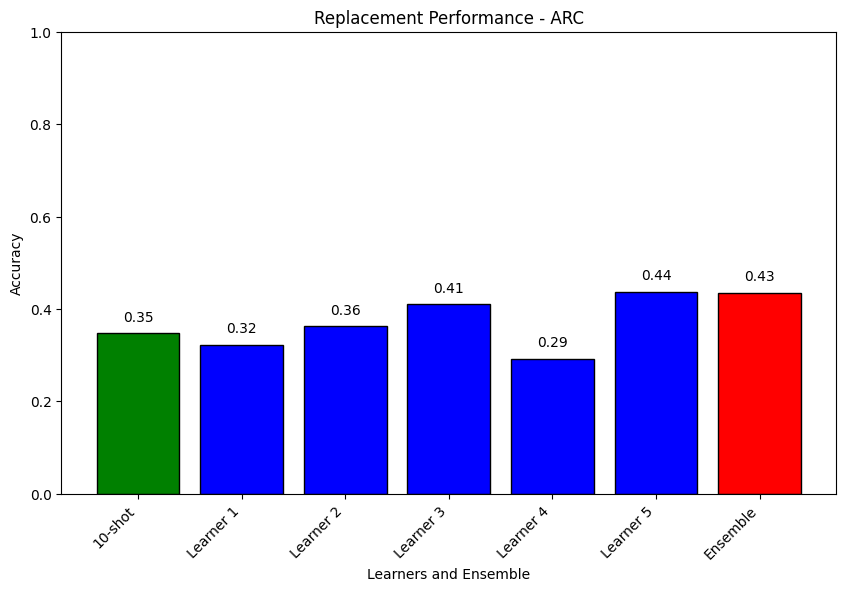

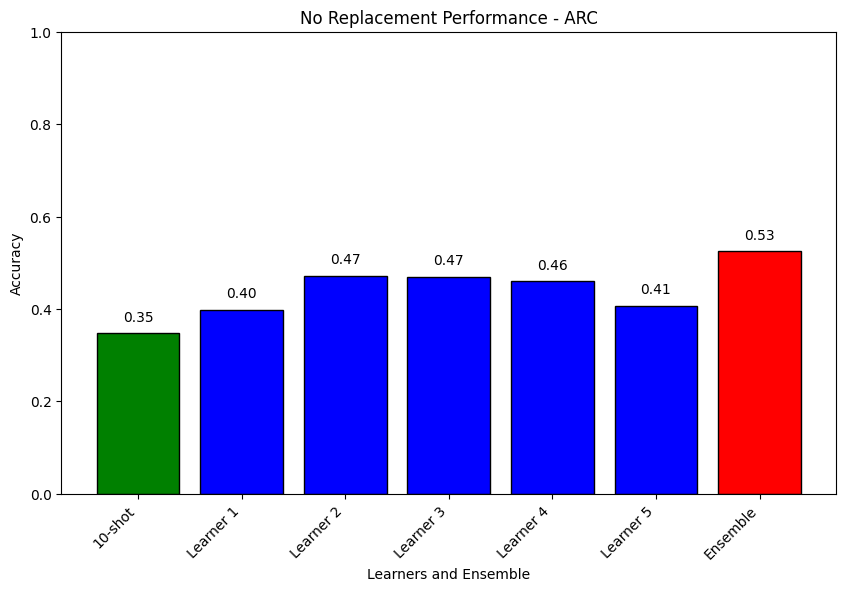

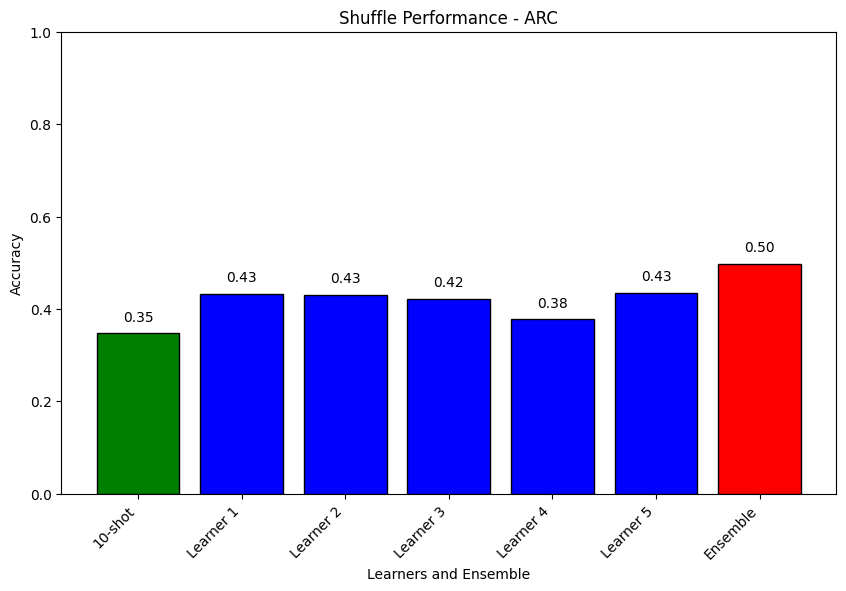

In [73]:
import matplotlib.pyplot as plt

# Performans verilerini al
individual_accuracies = {
    "Replacement": replacement_individual_accuracies,
    "No Replacement": no_replacement_individual_accuracies,
    "Shuffle": shuffled_individual_accuracies,
}

ensemble_accuracies = {
    "Replacement": replacement_ensemble_accuracy,
    "No Replacement": no_replacement_ensemble_accuracy,
    "Shuffle": shuffled_ensemble_accuracy,
}

# Grafik çizimi
for method_name, individuals in individual_accuracies.items():
    ensemble = ensemble_accuracies[method_name]

    # Çubuk grafik için veriler
    x_labels = ['10-shot'] + [f'Learner {i+1}' for i in range(len(individuals))] + ['Ensemble']
    x_positions = np.arange(len(x_labels))
    accuracies = [0.3475] + individuals + [ensemble]  # Manuel olarak 10-shot değerini ekle
    colors = ['green'] + ['blue'] * len(individuals) + ['red']

    # Çizim
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_positions, accuracies, color=colors, edgecolor="black")
    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylim(0, 1)  # Doğruluk oranları 0 ile 1 arasında varsayıldı
    plt.title(f'{method_name} Performance - ARC')
    plt.ylabel('Accuracy')
    plt.xlabel('Learners and Ensemble')

    # Bar'ların üzerine değer ekleme
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()

In [64]:
# hellaswag verilerini yükle ve temizle
hellaswag_replacement_file = os.path.join(DATA_PATH, "hellaswag_replacement_ensemble_results_OnlyChoice_ens5.csv")
hellaswag_no_replacement_file = os.path.join(DATA_PATH, "hellaswag_no_replacement_ensemble_results_OnlyChoice_ens5.csv")
hellaswag_shuffled_file = os.path.join(DATA_PATH, "hellaswag_shuffled_ensemble_results_OnlyChoice_ens5.csv")


questions_hellaswag_Rep, true_answers_hellaswag_Rep, model_predictions_hellaswag_Rep, hellaswag_replacement_df = load_data_from_csv(hellaswag_replacement_file)
question_hellaswag_noRep, true_answers_hellaswag_noRep, model_predictions_hellaswag_noRep, hellaswag_no_replacement_df = load_data_from_csv(hellaswag_no_replacement_file)
question_hellaswag_Shuf, true_answers_hellaswag_Shuf, model_predictions_hellaswag_Shuf, hellaswag_shuffled_df = load_data_from_csv(hellaswag_shuffled_file)

# Tahminleri temizle
hellaswag_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_Rep)
hellaswag_no_replacement_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_noRep)
hellaswag_shuffled_df["cleaned_answer"] = clean_predictions(model_predictions_hellaswag_Shuf)

# Örnek çıktıları yazdır
print_sample_predictions(questions_hellaswag_Rep, true_answers_hellaswag_Rep, model_predictions_hellaswag_Rep, hellaswag_replacement_df["cleaned_answer"].tolist(), "Hellaswag Replacement")


=== Hellaswag Replacement Tahminleri (İlk 5 Örnek) ===
Soru 1:
  Kırmızı gömlekli bir adam ellerini çırpıyor. Bir pistte koşuyor ve kuma atlıyor. insanlar
Şıklar:
A. Stadyumda durup onu izliyorlar.
B. bekleme odasında oturup izliyorlar.
C. daha sonra kumu tırmıklayın.
D. onun koşmasını izliyoruz.
  Gerçek Cevap: C
  Orijinal Tahmin: B
Soru: Bir adam bir yolda yürüyor. Yolda
Şıklar:
A. bir bisikletin üzerinde duruyor.
B. bir ağaç dalı kırılıyor.
C. bir köpek ona doğru koşuyor.
D
  Temizlenmiş Tahmin: B
---
Soru 2:
  Bir kişi bir diski birkaç kez uzak mesafeye fırlatıyor. mavi gömlekli bir kadın
Şıklar:
A. oturup onu izliyor.
B. diski bir enerji tabancasıyla yakalıyor.
C. aynı zamanda bir diski birkaç kez uzağa fırlatıyor.
D. onların arkasında yürüyor.
  Gerçek Cevap: A
  Orijinal Tahmin: B
S
  Temizlenmiş Tahmin: B
---
Soru 3:
  İnsanlar bir binanın önünde paten kayıyor. A
Şıklar:
A. kız kameranın önünde duruyor ve konuşuyor.
B. Adam konuşurken merdivenlerden piste çıkıyor.
C. Adam sil

In [65]:
# Replacement analizi
print("\n--- Hellaswag-TR ---")
print("\n--- Replacement Performans Analizi ---\n")
replacement_individual_accuracies = calculate_individual_performance(hellaswag_replacement_df, "Replacement")
replacement_ensemble_accuracy = calculate_ensemble_performance(hellaswag_replacement_df, "Replacement")

# No Replacement
print("\n--- No Replacement Performans Analizi ---\n")
no_replacement_individual_accuracies = calculate_individual_performance(hellaswag_no_replacement_df, "No Replacement")
no_replacement_ensemble_accuracy = calculate_ensemble_performance(hellaswag_no_replacement_df, "No Replacement")

# Shuffle
print("\n--- Shuffle Performans Analizi ---\n")
shuffled_individual_accuracies = calculate_individual_performance(hellaswag_shuffled_df, "Shuffle")
shuffled_ensemble_accuracy = calculate_ensemble_performance(hellaswag_shuffled_df, "Shuffle")


--- Hellaswag-TR ---

--- Replacement Performans Analizi ---

Replacement - Ensemble ID 1 Tekil Doğruluk: 0.2650
Replacement - Ensemble ID 2 Tekil Doğruluk: 0.2700
Replacement - Ensemble ID 3 Tekil Doğruluk: 0.2150
Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2425
Replacement - Ensemble ID 5 Tekil Doğruluk: 0.2525
Replacement - Ensemble Doğruluk: 0.2750

--- No Replacement Performans Analizi ---

No Replacement - Ensemble ID 1 Tekil Doğruluk: 0.2525
No Replacement - Ensemble ID 2 Tekil Doğruluk: 0.2300
No Replacement - Ensemble ID 3 Tekil Doğruluk: 0.2500
No Replacement - Ensemble ID 4 Tekil Doğruluk: 0.2400
No Replacement - Ensemble ID 5 Tekil Doğruluk: 0.2300
No Replacement - Ensemble Doğruluk: 0.2300

--- Shuffle Performans Analizi ---

Shuffle - Ensemble ID 1 Tekil Doğruluk: 0.2625
Shuffle - Ensemble ID 2 Tekil Doğruluk: 0.2050
Shuffle - Ensemble ID 3 Tekil Doğruluk: 0.2550
Shuffle - Ensemble ID 4 Tekil Doğruluk: 0.2375
Shuffle - Ensemble ID 5 Tekil Doğruluk: 0.2450
Shuffle - Ens

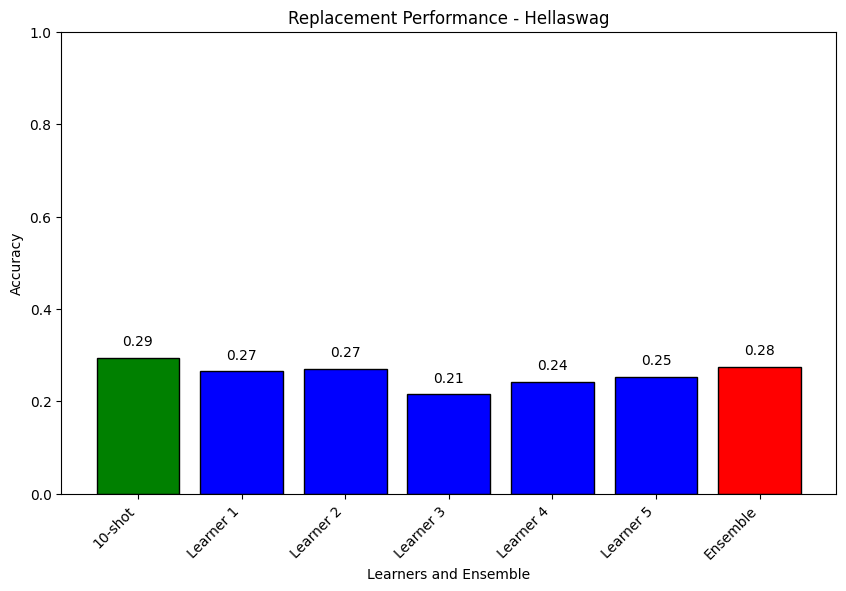

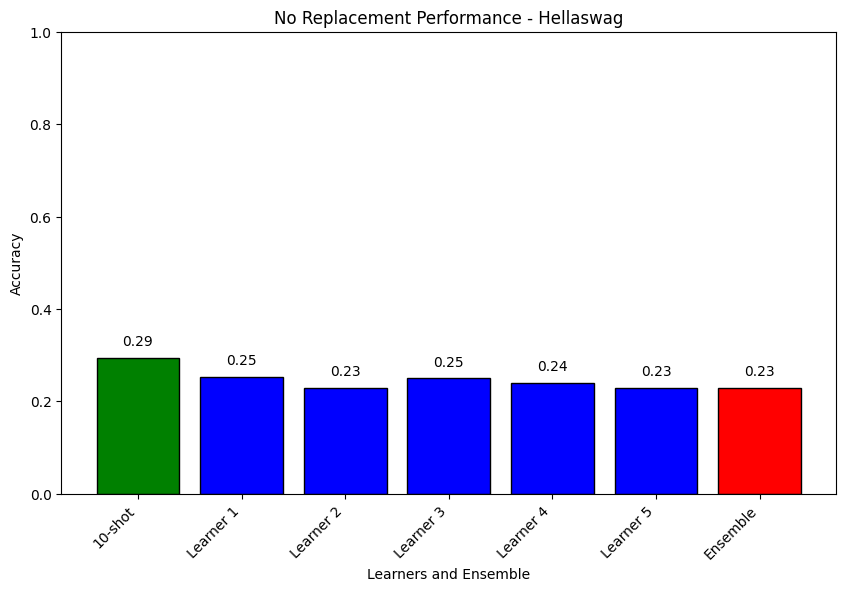

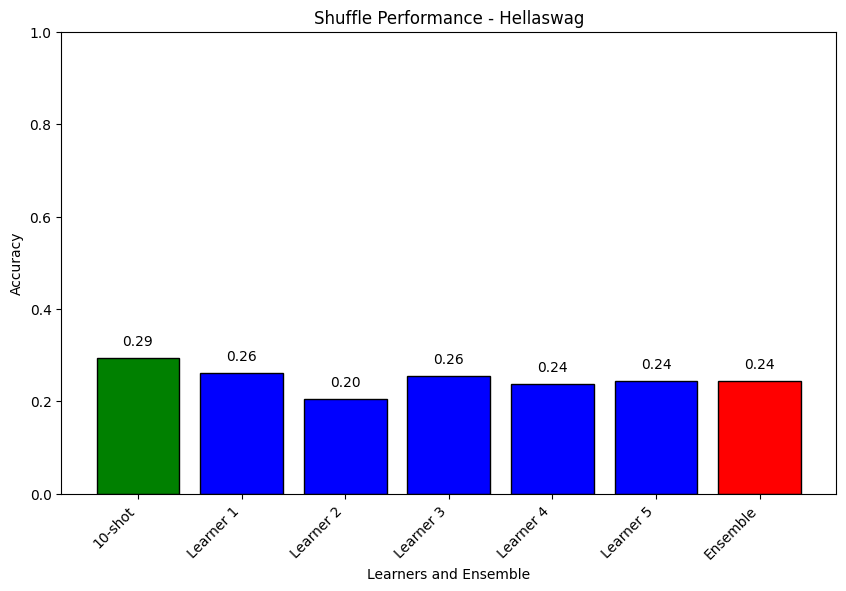

In [71]:
import matplotlib.pyplot as plt

# Performans verilerini al
individual_accuracies = {
    "Replacement": replacement_individual_accuracies,
    "No Replacement": no_replacement_individual_accuracies,
    "Shuffle": shuffled_individual_accuracies,
}

ensemble_accuracies = {
    "Replacement": replacement_ensemble_accuracy,
    "No Replacement": no_replacement_ensemble_accuracy,
    "Shuffle": shuffled_ensemble_accuracy,
}

# Grafik çizimi
for method_name, individuals in individual_accuracies.items():
    ensemble = ensemble_accuracies[method_name]

    # Çubuk grafik için veriler
    x_labels = ['10-shot'] + [f'Learner {i+1}' for i in range(len(individuals))] + ['Ensemble']
    x_positions = np.arange(len(x_labels))
    accuracies = [0.2950] + individuals + [ensemble]  # Manuel olarak 10-shot değerini ekle
    colors = ['green'] + ['blue'] * len(individuals) + ['red']

    # Çizim
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_positions, accuracies, color=colors, edgecolor="black")
    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.ylim(0, 1)  # Doğruluk oranları 0 ile 1 arasında varsayıldı
    plt.title(f'{method_name} Performance - Hellaswag')
    plt.ylabel('Accuracy')
    plt.xlabel('Learners and Ensemble')

    # Bar'ların üzerine değer ekleme
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
                 f'{accuracy:.2f}', ha='center', va='bottom', fontsize=10)

    plt.show()